## Load Required Libraries

In [1]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

The data and code book can be viewed at https://archive.ics.uci.edu/ml/datasets/Absenteeism+at+work

## Attribute Description

- Individual identification (ID)
- Reason for absence (ICD).

Absences attested by the International Code of Diseases (ICD) stratified into 21 categories (I to XXI) as follows:

I. Certain infectious and parasitic diseases  
II. Neoplasms  
III. Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism  
IV. Endocrine, nutritional and metabolic diseases  
V. Mental and behavioural disorders  
VI. Diseases of the nervous system  
VII. Diseases of the eye and adnexa  
VIII. Diseases of the ear and mastoid process  
IX. Diseases of the circulatory system  
X. Diseases of the respiratory system  
XI. Diseases of the digestive system  
XII. Diseases of the skin and subcutaneous tissue  
XIII. Diseases of the musculoskeletal system and connective tissue  
XIV. Diseases of the genitourinary system  
XV. Pregnancy, childbirth and the puerperium  
XVI. Certain conditions originating in the perinatal period  
XVII. Congenital malformations, deformations and chromosomal abnormalities  
XVIII. Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified  
XIX. Injury, poisoning and certain other consequences of external causes  
XX. External causes of morbidity and mortality  
XXI. Factors influencing health status and contact with health services  

And 7 categories without (CID) patient follow-up (22), medical consultation (23), blood donation (24), laboratory examination (25), unjustified absence (26), physiotherapy (27), dental consultation (28).

- Month of absence
- Day of the week (Monday (2), Tuesday (3), Wednesday (4), Thursday (5), Friday (6))
- Seasons (summer (1), autumn (2), winter (3), spring (4))
- Transportation expense
- Distance from Residence to Work (kilometers)
- Service time
- Age
- Work load Average/day
- Hit target
- Disciplinary failure (yes=1; no=0)
- Education (high school (1), graduate (2), postgraduate (3), master and doctor (4))
- Son (number of children)
- Social drinker (yes=1; no=0)
- Social smoker (yes=1; no=0)
- Pet (number of pet)
- Weight
- Height
- Body mass index
- Absenteeism time in hours (target) 

## Load Data

In [2]:
colnames = ['ID', 'Reason', 'Month', 'WeekDay', 'Season', 'TravelExpense', 'TravelDistance',
             'ServiceTime', 'Age', 'WorkLoad', 'HitTarget', 'DisciplinaryFailure', 'Education',
             'Son', 'SocialDrinker', 'SocialSmoker', 'Pet', 'Weight', 'Height', 'BMI', 'Absenteeism']

df = pd.read_csv("data\Absenteeism_at_work.csv",
                 sep=";",
                 skiprows = 1,
                 header=None,
                 names = colnames)
print(df.shape)
df.head()

(740, 21)


,ID,Reason,Month,WeekDay,Season,TravelExpense,TravelDistance,ServiceTime,Age,WorkLoad,...,DisciplinaryFailure,Education,Son,SocialDrinker,SocialSmoker,Pet,Weight,Height,BMI,Absenteeism
0,11,26,7,3,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,...,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,...,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,...,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,...,0,1,2,1,0,1,90,172,30,2


Some data visualizations can be seen at https://public.tableau.com/profile/mccloud77#!/vizhome/Absenteeism_2/Dashboard1?publish=yes from which it can be inferred that no simple linear relationship between `absenteeism time in hours` and some (if not all) of the other explanatory variables exists.

## Data Exploration

In [3]:
# Check any number of columns with NaN
print(df.isnull().any().sum(), ' / ', len(df.columns))
# Check any number of data points with NaN
print(df.isnull().any(axis=1).sum(), ' / ', len(df))

0  /  21
0  /  740


Examine correlations.

In [4]:
corr = df.iloc[:, 2:].corr()
corr.style.background_gradient()

,Month,WeekDay,Season,TravelExpense,TravelDistance,ServiceTime,Age,WorkLoad,HitTarget,DisciplinaryFailure,Education,Son,SocialDrinker,SocialSmoker,Pet,Weight,Height,BMI,Absenteeism
Month,1,-0.00652801,0.40777,0.137525,-0.00388726,-0.0628623,-0.00151954,-0.169989,-0.460453,0.107946,-0.0661277,0.0790313,0.0562262,-0.0386025,0.0477873,0.0232783,-0.0689424,0.0510463,0.0243454
WeekDay,-0.00652801,1,0.0464935,0.0339882,0.118026,0.0212523,0.00445883,0.0156461,0.0309861,-0.0151204,0.0585159,0.0980788,0.0417723,0.0131556,-0.0288851,-0.12898,-0.0821332,-0.103578,-0.124361
Season,0.40777,0.0464935,1,0.0369949,-0.0631084,-0.0109037,-0.0120885,0.150439,-0.0611541,0.151766,-0.0029511,0.0469502,-0.0459819,-0.0486707,0.0123565,-0.0262776,-0.0337374,-0.0110311,-0.00561498
TravelExpense,0.137525,0.0339882,0.0369949,1,0.262183,-0.349887,-0.227542,0.00543806,-0.080193,0.109222,-0.0550648,0.383001,0.145117,0.0443561,0.40008,-0.207435,-0.194496,-0.136517,0.0275846
TravelDistance,-0.00388726,0.118026,-0.0631084,0.262183,1,0.13173,-0.145886,-0.068677,-0.0138646,-0.0565271,-0.259605,0.0542304,0.452196,-0.0753688,0.205941,-0.0478591,-0.353372,0.113772,-0.0883628
ServiceTime,-0.0628623,0.0212523,-0.0109037,-0.349887,0.13173,1,0.670979,-0.000668491,-0.00784003,-0.00022116,-0.213,-0.0471284,0.353141,0.0724243,-0.440301,0.455975,-0.0531345,0.499718,0.0190293
Age,-0.00151954,0.00445883,-0.0120885,-0.227542,-0.145886,0.670979,1,-0.0394252,-0.0392243,0.104304,-0.221882,0.0569841,0.213183,0.121738,-0.231226,0.41873,-0.0629966,0.470688,0.0657597
WorkLoad,-0.169989,0.0156461,0.150439,0.00543806,-0.068677,-0.000668491,-0.0394252,1,-0.089445,0.0290258,-0.0749596,0.0278202,-0.0337126,0.0309683,0.0071142,-0.0385216,0.103315,-0.0907093,0.0247489
HitTarget,-0.460453,0.0309861,-0.0611541,-0.080193,-0.0138646,-0.00784003,-0.0392243,-0.089445,1,-0.147971,0.101062,-0.0140906,-0.10248,0.0512539,0.00720128,-0.0449474,0.0932669,-0.0889395,0.0266951
DisciplinaryFailure,0.107946,-0.0151204,0.151766,0.109222,-0.0565271,-0.00022116,0.104304,0.0290258,-0.147971,1,-0.0592982,0.0720963,0.051838,0.116748,0.0188814,0.0722246,-0.0104984,0.0794282,-0.124248


The only strong correlations evident are those between `Weight` and `BMI` and between `Height` and `BMI` which is to expected since BMI is calculated from the weight and height measurements of an individual.

## Visualize some Variables

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002360B06D710>]], dtype=object)

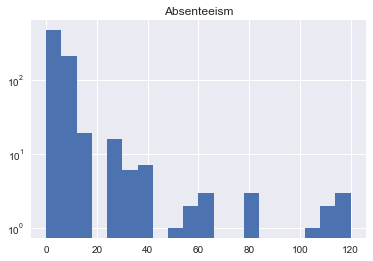

In [5]:
# Use a log scale to plot absentee hours
df.hist(column="Absenteeism", bins=20, log=True)

In [6]:
# Count number of observations for absenteeism
df['Absenteeism'].value_counts(sort=True)

8      208
2      157
3      112
1       88
4       60
0       44
16      19
24      16
40       7
5        7
32       6
64       3
80       3
120      3
112      2
56       2
48       1
7        1
104      1
Name: Absenteeism, dtype: int64

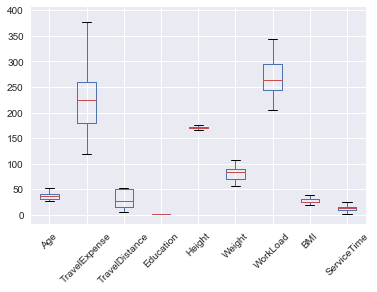

In [7]:
df.boxplot(['Age', 'TravelExpense', 'TravelDistance',
            'Education', 'Height', 'Weight', 'WorkLoad', 'BMI',
            'ServiceTime'], rot=45)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002360B9EF4E0>]], dtype=object)

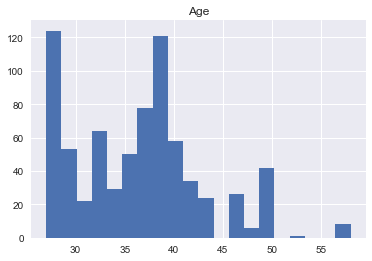

In [8]:
df.hist(column='Age', bins=20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002360B5CE668>]], dtype=object)

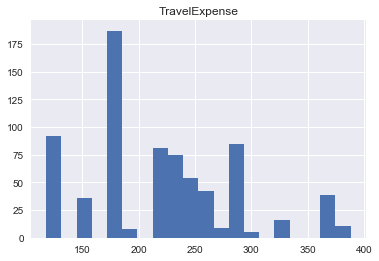

In [9]:
df.hist(column='TravelExpense', bins=20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002360BA39198>]], dtype=object)

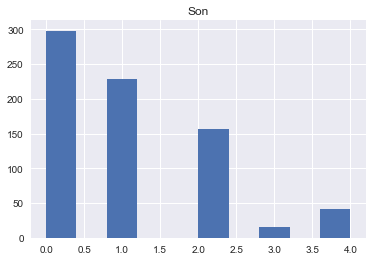

In [10]:
df.hist(column='Son')

For classification purposes, we may want to group `Absenteeism` into two groups, one that exceeds a certain number of hours (`1`) and one that does not (`0`).

## Preprocess Data

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
df.drop(['ID'], inplace=True, axis=1)

In [13]:
# Use one hot encoding for categorical and ordinal features (although they appear numerical)
dummy_column_names = ['Reason', 'Month', 'WeekDay', 'Season', 'HitTarget', 'Education', 'Son', 'Pet']
df_dummy = df[dummy_column_names]
df_dummy = pd.get_dummies(df_dummy, columns=dummy_column_names, drop_first=True)
print(df_dummy.shape)
df_dummy.head()

(740, 70)


,Reason_1,Reason_2,Reason_3,Reason_4,Reason_5,Reason_6,Reason_7,Reason_8,Reason_9,Reason_10,...,Education_4,Son_1,Son_2,Son_3,Son_4,Pet_1,Pet_2,Pet_4,Pet_5,Pet_8
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [14]:
# Normalize numerical features
scaled_column_names = ['TravelExpense', 'TravelDistance', 'ServiceTime', 'Age', 'WorkLoad',
                       'Weight', 'Height', 'BMI']
scaled_features = StandardScaler().fit_transform(df[scaled_column_names])

In [15]:
df_scaled_features = pd.DataFrame(scaled_features, index=df.index, columns=scaled_column_names)

In [16]:
# Join dataframes
df_mod = pd.concat([df_dummy, df_scaled_features,
                   df[['SocialDrinker', 'DisciplinaryFailure', 'SocialSmoker', 'Absenteeism']]], axis=1)
print(df_mod.shape)
df_mod.head()

(740, 82)


,Reason_1,Reason_2,Reason_3,Reason_4,Reason_5,Reason_6,Reason_7,Reason_8,Reason_9,Reason_10,...,ServiceTime,Age,WorkLoad,Weight,Height,BMI,SocialDrinker,DisciplinaryFailure,SocialSmoker,Absenteeism
0,0,0,0,0,0,0,0,0,0,0,...,0.101770,-0.532868,-0.818212,0.851673,-0.019046,0.775932,1,0,0,4
1,0,0,0,0,0,0,0,0,0,0,...,1.242825,2.092860,-0.818212,1.473056,0.975828,1.009438,1,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1.242825,0.239405,-0.818212,0.774000,-0.350671,1.009438,1,0,0,2
3,0,0,0,0,0,0,1,0,0,0,...,0.329981,0.393859,-0.818212,-0.857131,-0.682295,-0.625100,1,0,1,4
4,0,0,0,0,0,0,0,0,0,0,...,0.101770,-0.532868,-0.818212,0.851673,-0.019046,0.775932,1,0,0,2


In [17]:
X = df_mod.loc[:, df_mod.columns != 'Absenteeism']
y = df_mod['Absenteeism']
print(X.shape)
print(y.shape)

(740, 81)
(740,)


## Split Data into Training and Test Sets

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

## Linear Regression

The (limited) data exploration in the previous section already indicated that (multiple) linear regression is probably not a good choice when trying to predict `Absenteeism` since most, if not all, of the features are not linearly related to the response variable. Nevertheless, lets try a multiple linear regression with a subset of the features.  

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html

In [20]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import r2_score

In [21]:
def ridge_regression(X, y):
    
    regr = RidgeCV(alphas=[0.1, 1.0, 10.0, 20.0, 50.0, 100.0])
    regr.fit(X_train, y_train)
    
    return regr.alpha_

features = np.asanyarray(X_train[scaled_column_names])
lbls = np.asanyarray(y_train)

alpha = ridge_regression(features, lbls)
print("Alpha from Ridge regression with cross validation:", alpha)

Alpha from Ridge regression with cross validation: 20.0


The relatively high value of alpha suggests that the model is underfitting and (ridge) regression is not recommended.  

Use Ridge regression with the suggested alpha to make predictions:

In [22]:
reg = Ridge(alpha=20.0)
reg.fit(X_train, y_train)
predictions = reg.predict(X_test)

print("Mean absolute error: %.2f" % np.mean(np.absolute(predictions - y_test)))
print("Residual sum of squares (MSE): %.2f" % np.mean((predictions - y_test) ** 2))
print("R2-score: %.2f" % r2_score(predictions , y_test))

Mean absolute error: 5.93
Residual sum of squares (MSE): 179.68
R2-score: -4.80


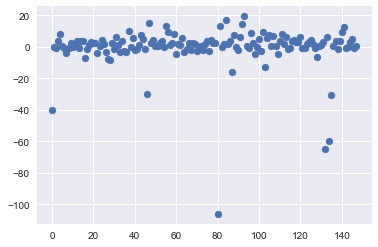

In [23]:
# Plot the residuals
resid = predictions - y_test
plt.scatter(range(len(resid)), resid)

The metrics show above indeed show that ridge (linear) regression does not hold much promise.

## Logistic Regression

Logistic regression typically requires a binary label (0/1, True/False, yes/no). Based on the variable `Absenteeism time in hours`, cases are assigned a `0` (does not exceed) or `1` (does exceed) based on user-specified cutoff value for classifiction purposes. Note that multiple classes are supported by `LogisticRegression` using the 'one versus rest` (OvR) scheme.  

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [24]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, jaccard_similarity_score, roc_curve,\
                            classification_report, log_loss, accuracy_score, roc_auc_score

The function `plot_confusion_matrix` can be used to plot a visual confusion matrix.

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #print(confusion_matrix(y_test, yhat, labels=[1,0]))

The function `plot_roc` can be used to plot the ROC AUC curve.

In [26]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on Absenteeism problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])

In order to evaluate the remaining algorithms, we choose a time cutoff value of 7 hours which gives the following:

In [27]:
print('Percent of cases exceeding at least 7 hours of absenteeism:', '{:.2f}'.format(sum(y>=7)/len(y)*100))

Percent of cases exceeding at least 7 hours of absenteeism: 36.76


Note that we can achieve an accuracy of approximately 64% by predicting that nobody will exceed at least 7 hours of absenteeism time.

In [28]:
# Prepare the (normalized) training and test sets
y_bin = np.where(y >= 7, 1, 0)
X = np.asarray(X)

X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=4)

In [29]:
def logistic_regression(X_train, y_train, X_test, y_test, prob='no'):
    
    lr = LogisticRegressionCV(
        Cs=list(np.power(10.0, np.arange(-10, 10))),
        penalty='l2', scoring='roc_auc')
    lr.fit(X_train, y_train)
    
    if prob == 'no':
        predictions = lr.predict(X_test)
        print('Accuracy on test set is {:.3f}'.format(accuracy_score(y_test, predictions)))
    else:
        predictions = lr.predict_log_proba(X_test)
        print('ROC AUC score:', lr.scores_[1].max())
    
    return predictions
    
predictions = logistic_regression(X_train, y_train, X_test, y_test)

Accuracy on test set is 0.838


ROC AUC score: 0.879241192412


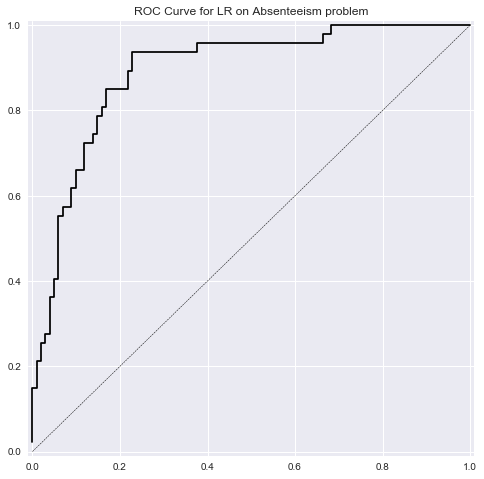

In [30]:
predictions_prob = logistic_regression(X_train, y_train, X_test, y_test, prob='yes')
plot_roc(y_test, predictions_prob[:,1], 'LR')

Confusion matrix, without normalization
[[40  7]
 [17 84]]


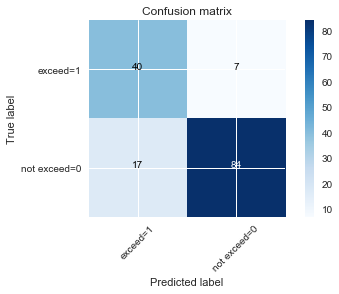

In [31]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predictions, labels=[1,0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['exceed=1','not exceed=0'], normalize=False,  title='Confusion matrix')

The number of false positives (predicted to exceed the time cutoff although they did not) was 17/148 or approximately 11%. The percentage of false negatives (not expected to exceed the time cutoff but did) was approximately 5% (7/148). Compared to linear regression this is a significant improvement although it should be mentioned that we have lost granularity by 'binning' the observations into two groups.

In [32]:
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.92      0.83      0.87       101
          1       0.70      0.85      0.77        47

avg / total       0.85      0.84      0.84       148



Log loss quantifies the accuracy of a classifier by penalizing false classifications. Minimizing the log loss is basically equivalent to maximizing the accuracy of the classifier. The log loss gradually declines as the predicted probability improves. Moving in the opposite direction though, the log loss ramps up very rapidly as the predicted probability approaches 0. In short, log loss heavily penalizes classifiers tht are confident about an incorrect classification.

In [33]:
print(log_loss(y_test, predictions_prob))

0.69314718056


## Support Vector Machine  

http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [34]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

In [35]:
def svm(X, y, C):
    """
    Using a support vector machine with cross validation
    """
    clf = SVC(kernel='linear', C=C)
    scores = cross_val_score(estimator=clf, X=X, y=y, cv=10, scoring='accuracy')
    return scores

In [36]:
cv_scores = []
for C in [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 1]:
    scores = svm(X_train, y_train, C)
    cv_scores.append(scores.mean())
    print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2), 'with C:', C)

Accuracy: 0.70 (+/- 0.05) with C: 0.01
Accuracy: 0.73 (+/- 0.05) with C: 0.02
Accuracy: 0.78 (+/- 0.05) with C: 0.03
Accuracy: 0.80 (+/- 0.07) with C: 0.04
Accuracy: 0.82 (+/- 0.08) with C: 0.05
Accuracy: 0.82 (+/- 0.07) with C: 0.1
Accuracy: 0.80 (+/- 0.10) with C: 1


In [37]:
def svm_test(X_train, y_train, X_test, y_test):
    clf = SVC(kernel='linear', C=0.05)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    print('Accuracy Score:', accuracy_score(y_test, predictions))
    
    return predictions

predictions_svm_test = svm_test(X_train, y_train, X_test, y_test)

Accuracy Score: 0.790540540541


Confusion matrix, without normalization
[[34 13]
 [18 83]]


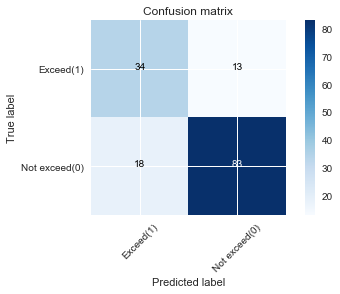

In [38]:
cnf_matrix = confusion_matrix(y_test, predictions_svm_test, labels=[1, 0])
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Exceed(1)','Not exceed(0)'],normalize= False,  title='Confusion matrix')

Small improvements may be possible by changing the penalty parameter C of the error term.

## Decision Trees

In [39]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_absolute_error

In [40]:
#Creating a function to determine the best fit n_estimators
def decision_tree(n_estimator, X_train, y_train, X_test, y_test):
    
    tree_model = AdaBoostRegressor(n_estimators=n_estimator)
    tree_model.fit(X_train, y_train)
    pred = tree_model.predict(X_test)
    
    return str(mean_absolute_error(pred, y_test))

for estimators in [100,500,1000,1500,2000,2500]:
    mae = decision_tree(estimators, X_train, y_train, X_test, y_test)
    print("Number of estimators: {}  \t\t Mean Absolute Error:  {}".format(estimators, mae))

Number of estimators: 100  		 Mean Absolute Error:  0.396298764152
Number of estimators: 500  		 Mean Absolute Error:  0.358156588232
Number of estimators: 1000  		 Mean Absolute Error:  0.334578131978
Number of estimators: 1500  		 Mean Absolute Error:  0.345067455972
Number of estimators: 2000  		 Mean Absolute Error:  0.322425702678
Number of estimators: 2500  		 Mean Absolute Error:  0.339020209233


In [41]:
def ada_boost(X_train, y_train, X_test, y_test, n_estimators=1000):
    
    tree_model = AdaBoostRegressor(n_estimators=n_estimators, learning_rate=0.05)
    tree_model.fit(X_train, y_train)
    
    predictions = tree_model.predict(X_test)
    
    return predictions

predictions = ada_boost(X_train, y_train, X_test, y_test)
print('Mean absolute error:', mean_absolute_error(y_test, predictions))
print('Accuracy score:', accuracy_score(y_test, np.round(predictions)))

Mean absolute error: 0.323559927474
Accuracy score: 0.722972972973


## Keras (Neural Network)

Dividing the response variable in just two categories, namely exceeds or does not exceed a specific number of absenteeism hours may not be optimal and definitely leds to loss of information. On the other hand, given the skewed distribution of the response variable any regression approach, with or without gradient descent optimization, will probably not yield a viable model.  

Nevertheless, it may be possible to bin the response variable in more than 2 categories and subsequently use a more sophisticated deep learning approach such as Keras.

In [42]:
from keras.models  import Sequential, K
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop

Using TensorFlow backend.


### Single Hidden Layer

 32/148 [=====>........................] - ETA: 0s
accuracy is 0.764
roc-auc is 0.863


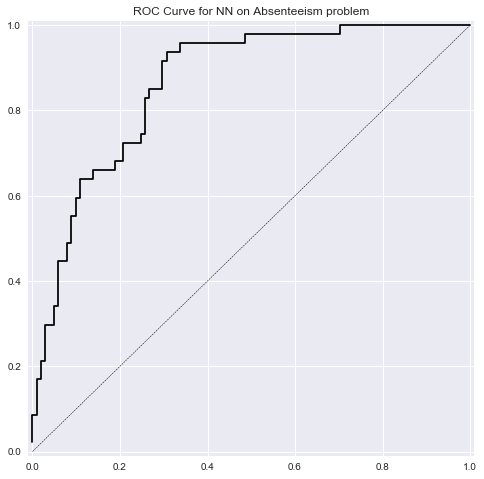

In [43]:
# Define the Model 
# Input size is 81-dimensional
# 1 hidden layer, 12 hidden nodes, relu activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)
model_1 = Sequential([
    Dense(12, input_shape=(81,), activation="relu"),
    Dense(1, activation="sigmoid")
])

#model_1.summary()
model_1.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_1 = model_1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=500, verbose=0)

## We generate two kinds of predictions
#  One is a hard decision, the other is a probabilitistic score.
y_pred_class_nn_1 = model_1.predict_classes(X_test)
y_pred_prob_nn_1 = model_1.predict(X_test)

# Print model performance and plot the roc curve
print('\naccuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_1)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

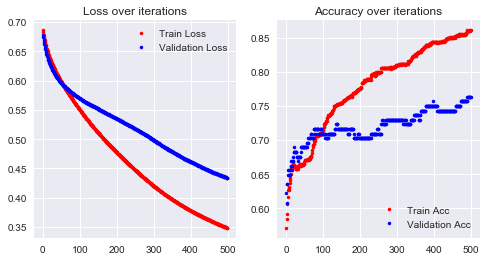

In [44]:
def plot_loss_accuracy(history):
    n = len(history["loss"])

    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(1,2,1)
    ax.plot(range(n), (history["loss"]), 'r.', label="Train Loss")
    ax.plot(range(n), (history["val_loss"]), 'b.', label="Validation Loss")
    ax.legend()
    ax.set_title('Loss over iterations')

    ax = fig.add_subplot(1,2,2)
    ax.plot(range(n), (history["acc"]), 'r.', label="Train Acc")
    ax.plot(range(n), (history["val_acc"]), 'b.', label="Validation Acc")
    ax.legend(loc='lower right')
    ax.set_title('Accuracy over iterations')

plot_loss_accuracy(run_hist_1.history)

### Two Hidden Layers

 32/148 [=====>........................] - ETA: 0s
accuracy is 0.770
roc-auc is 0.861


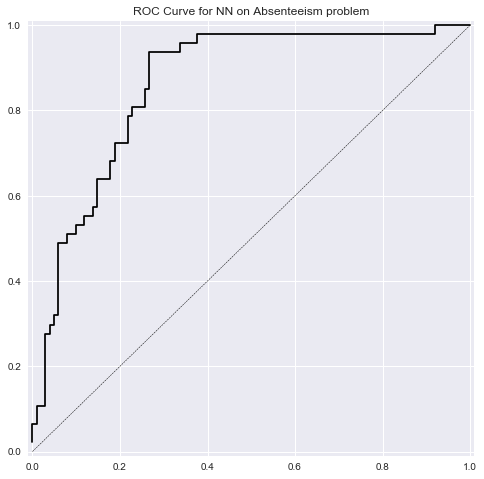

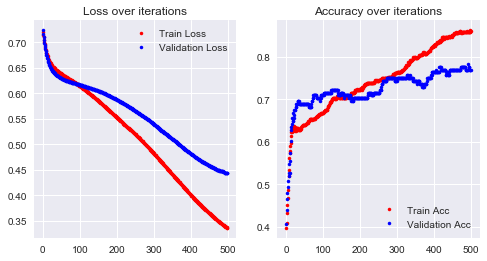

In [45]:
model_2 = Sequential([
    Dense(12, input_shape=(81,), activation="relu"),
    Dense(12, activation="relu"),
    Dense(1, activation="sigmoid")
])

model_2.compile(SGD(lr = .003), "binary_crossentropy", metrics=["accuracy"])
run_hist_2 = model_2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=500, verbose=0)

y_pred_class_nn_2 = model_2.predict_classes(X_test)
y_pred_prob_nn_2 = model_2.predict(X_test)

print('\naccuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_2)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_2)))

plot_roc(y_test, y_pred_prob_nn_2, 'NN')

plot_loss_accuracy(run_hist_2.history)

### Three Hidden Layers with Dropout

In [46]:
exec_flag = 0

In [47]:
if exec_flag ==1:
    model_3 = Sequential()
    model_3.add(Dense(12, activation='relu', input_shape=(81,)))
    model_3.add(Dropout(0.1))
    model_3.add(Dense(12, activation='relu'))
    model_3.add(Dropout(0.1))
    model_3.add(Dense(1, activation='sigmoid'))

    # Add Dropout layers and increase learning rate slightly
    model_3.compile(SGD(lr = .004, nesterov=True), "binary_crossentropy", metrics=["accuracy"])
    run_hist_3 = model_3.fit(X_train, y_train, validation_split=0.1, epochs=500, verbose=0)

    y_pred_class_nn_3 = model_3.predict_classes(X_test)
    y_pred_prob_nn_3 = model_3.predict(X_test)

    print('\naccuracy is {:.3f}'.format(accuracy_score(y_test,y_pred_class_nn_3)))
    print('roc-auc is {:.3f}'.format(roc_auc_score(y_test,y_pred_prob_nn_3)))

    plot_roc(y_test, y_pred_prob_nn_3, 'NN')

    plot_loss_accuracy(run_hist_3.history)
    model_3.save('model/nn_absenteeism_model.h5')
    from keras.models import load_model
    new_model = load_model('model/nn_absenteeism_model.h5')
    new_model.summary()